In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import rasterio as rio
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_nl_means
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from src.denoising import denoise_swt, apply_wavelet, apply_tv, apply_nlm, apply_bil
from src.ecs import ECS
from src.segmentation import segment2d, segment_metrics
from src.preproc import save_with_rio

In [2]:
def load_all_startswith(directory, starts_with):
    files = [directory + "/" + f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f)) and f.startswith(starts_with)]
    def extract_number(s):
        match = re.search(r'\d+', s)
        return int(match.group()) if match else float('inf')
    
    sorted_files = sorted(files, key=extract_number)

    X = []
    for i in sorted_files:
        temp = rio.open(i)
        X.append(temp.read())
        temp.close()
    X = np.concatenate(X)

    return X

In [3]:
scaled = load_all_startswith('data/scaled/', 'scaled')

In [4]:
scaled = scaled[:,:,:-3]

In [5]:
def add_noise(img, std_dev=1, avg=0):
    noise = np.random.normal(avg, std_dev, img.shape)
    noised = np.add(img, noise)
    return noised

In [6]:
original = scaled[0]
example = add_noise(original, 0.1)
noisy_wav = denoise_swt(example)
noisy_tv = denoise_tv_chambolle(example, weight=0.2)
noisy_bil = denoise_bilateral(example)
noisy_nlm = denoise_nl_means(example)

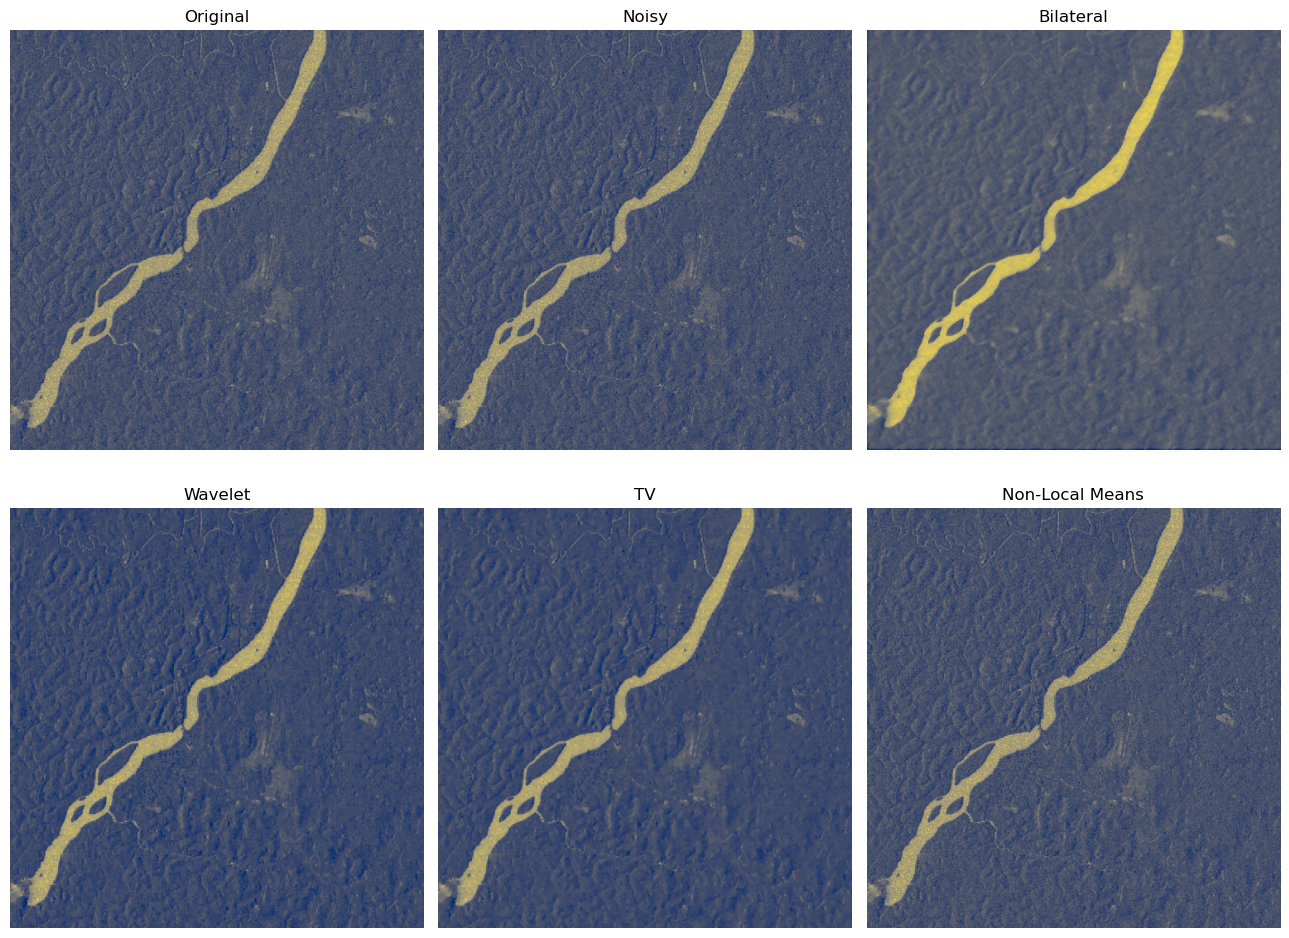

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(13, 10))

palette = 'cividis'

axes[0, 0].imshow(original, cmap=palette)
axes[0, 0].set_title("Original")
axes[0, 0].set_axis_off()

axes[0, 1].imshow(example, cmap=palette)
axes[0, 1].set_title("Noisy")
axes[0, 1].set_axis_off()

axes[1, 0].imshow(noisy_wav, cmap=palette)
axes[1, 0].set_title("Wavelet")
axes[1, 0].set_axis_off()

axes[1, 1].imshow(noisy_tv, cmap=palette)
axes[1, 1].set_title("TV")
axes[1, 1].set_axis_off()

axes[0, 2].imshow(noisy_bil, cmap=palette)
axes[0, 2].set_title("Bilateral")
axes[0, 2].set_axis_off()

axes[1, 2].imshow(noisy_nlm, cmap=palette)
axes[1, 2].set_title("Non-Local Means")
axes[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

In [8]:
ssim_wav = structural_similarity(original, noisy_wav, data_range=noisy_wav.max() - noisy_wav.min())
ssim_tv = structural_similarity(original, noisy_tv, data_range=noisy_tv.max() - noisy_tv.min())
ssim_bil = structural_similarity(original, noisy_bil, data_range=noisy_bil.max() - noisy_bil.min())
ssim_nlm = structural_similarity(original, noisy_nlm, data_range=noisy_nlm.max() - noisy_nlm.min())

print('SSim Wavelet: ', str(ssim_wav), '\nSSim TV: ', str(ssim_tv), '\nSSim Bilateral: ', str(ssim_bil), '\nSSim Non-Local Means: ', str(ssim_nlm))

SSim Wavelet:  0.8525052731550401 
SSim TV:  0.7871826122696925 
SSim Bilateral:  0.3560760587693342 
SSim Non-Local Means:  0.9796533420362904


In [9]:
psnr_wav = peak_signal_noise_ratio(noisy_wav, example, data_range=noisy_wav.max() - noisy_wav.min())
psnr_tv = peak_signal_noise_ratio(noisy_tv, example, data_range=noisy_tv.max() - noisy_tv.min())
psnr_bil = peak_signal_noise_ratio(noisy_bil, example, data_range=noisy_bil.max() - noisy_bil.min())
psnr_nlm = peak_signal_noise_ratio(noisy_nlm, example, data_range=noisy_nlm.max() - noisy_nlm.min())

print('PSNR Wavelet: ', str(psnr_wav), '\nPSNR TV: ', str(psnr_tv), '\nPSNR Bilateral: ', str(psnr_bil), '\nPSNR Non-Local Means: ', str(psnr_nlm))

PSNR Wavelet:  30.50479085904422 
PSNR TV:  29.450675616615985 
PSNR Bilateral:  23.670168215436398 
PSNR Non-Local Means:  101.13265514388134


In [10]:
denoised_wav = apply_wavelet(scaled)
print('\n')
denoised_tv = apply_tv(scaled, w=0.2)
print('\n')
denoised_nlm = apply_nlm(scaled)
print('\n')
denoised_bil = apply_bil(scaled)

Applying Wavelet:  81 / 81

Applying TV:  81 / 81

Applying NLM:  81 / 81



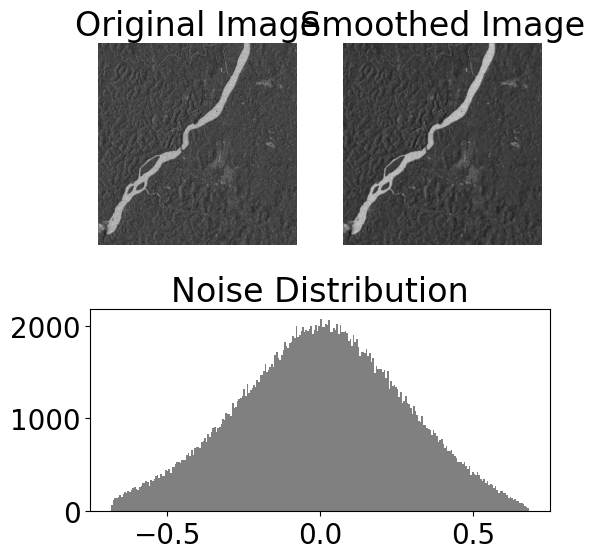

In [145]:
fig = plt.figure(figsize=(6, 6))

palette = 'gray'

mean_scaled = scaled[0]
mean_smooth = denoised_tv[0]

noise = mean_smooth - mean_scaled

fig.add_subplot(221)
plt.title('Original Image')
plt.set_cmap(palette)
plt.imshow(mean_scaled)
plt.axis('off')

fig.add_subplot(222)
plt.title('Smoothed Image')
plt.set_cmap(palette)
plt.imshow(mean_smooth)
plt.axis('off')

fig.add_subplot(212)
plt.title('Noise Distribution')
plt.hist(noise.flatten(), 256, color='gray')

plt.tight_layout()
plt.show()

In [11]:
ecs_wav = ECS(scaled, smooth_img=denoised_wav)
ecs_tv = ECS(scaled, smooth_img=denoised_tv)
ecs_nlm = ECS(scaled, smooth_img=denoised_nlm)
ecs_bil = ECS(scaled, smooth_img=denoised_bil)

In [12]:
ecs_wav_seg = segment2d(ecs_wav, method='ki')
ecs_tv_seg = segment2d(ecs_tv, method='ki')
ecs_nlm_seg = segment2d(ecs_nlm, method='ki')
ecs_bil_seg = segment2d(ecs_bil, method='ki')

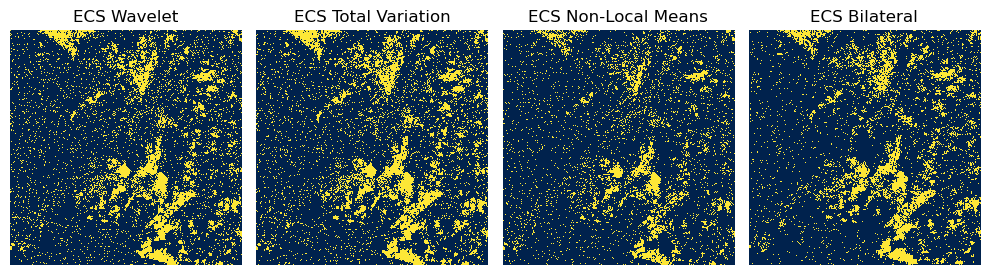

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(10, 13))

palette = 'cividis'

axes[0].imshow(ecs_wav_seg, interpolation='nearest', cmap=palette)
axes[0].set_title('ECS Wavelet')
axes[0].set_axis_off()

axes[1].imshow(ecs_tv_seg, interpolation='nearest', cmap=palette)
axes[1].set_title('ECS Total Variation')
axes[1].set_axis_off()

axes[2].imshow(ecs_nlm_seg, interpolation='nearest', cmap=palette)
axes[2].set_title('ECS Non-Local Means')
axes[2].set_axis_off()

axes[3].imshow(ecs_bil_seg, interpolation='nearest', cmap=palette)
axes[3].set_title('ECS Bilateral')
axes[3].set_axis_off()

plt.tight_layout()
plt.show()

In [14]:
temp = rio.open('data/scaled/scaled_0.tif')
temp.close()

In [15]:
save_with_rio('results/ecs_wav.tif', ecs_wav_seg, temp)
save_with_rio('results/ecs_tv.tif', ecs_tv_seg, temp)
save_with_rio('results/ecs_nlm.tif', ecs_nlm_seg, temp)
save_with_rio('results/ecs_bil.tif', ecs_bil_seg, temp)

True

In [16]:
ecs_wav_metrics, _, _ = segment_metrics('results/ecs_wav.tif', 'data/shp/Change.shp', 'data/shp/NonChange.shp')
ecs_tv_metrics, _, _ = segment_metrics('results/ecs_tv.tif', 'data/shp/Change.shp', 'data/shp/NonChange.shp')
ecs_nlm_metrics, _, _ = segment_metrics('results/ecs_nlm.tif', 'data/shp/Change.shp', 'data/shp/NonChange.shp')
ecs_bil_metrics, _, _ = segment_metrics('results/ecs_bil.tif', 'data/shp/Change.shp', 'data/shp/NonChange.shp')

In [17]:
ecs_wav_metrics['model'] = 'Wavelet'
ecs_tv_metrics['model'] = 'Total Variation'
ecs_nlm_metrics['model'] = 'Non-Local Means'
ecs_bil_metrics['model'] = 'Bilateral'

metrics = pd.DataFrame([ecs_wav_metrics, ecs_tv_metrics, ecs_nlm_metrics, ecs_bil_metrics])
metrics

,f1,precision,recall,accuracy,model
0,0.826487,0.948045,0.732558,0.788293,Wavelet
1,0.841644,0.946270,0.757851,0.803715,Total Variation
2,0.726958,0.950768,0.588440,0.695759,Non-Local Means
3,0.769808,0.956631,0.644033,0.734899,Bilateral


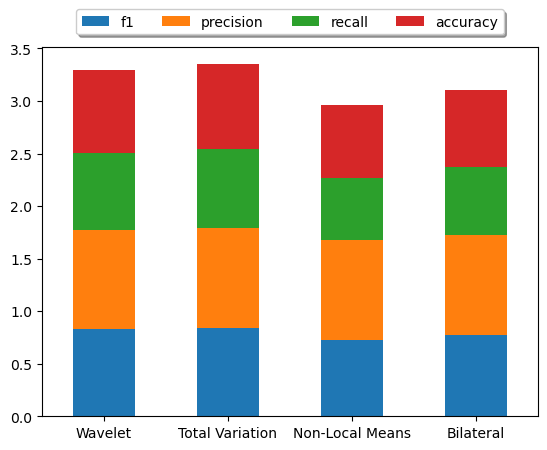

In [18]:
ax = metrics.plot(
    x='model',
    kind='bar',
    stacked=True,
    xlabel=''
)
ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.12), fancybox=True, shadow=True)
plt.xticks(rotation=0)
plt.show()

In [140]:
import tempfile

In [ ]:
def AutoDECS(data, *smoothing_fns, change_shp=None, nonchange_shp=None):
    assert isinstance(data, (list, set)), 'data must be an iterable of file paths'
    assert all(os.path.isfile(file) and file.lower().endswith(('.tif', '.tiff')) for file in data), "every path in 'data' must be a tif file"
    assert len(smoothing_fns) > 0, "'smoothing_fns' needs to be bigger than 0 (pass smoothing functions)"

    X = []
    for i in data:
        temp = rio.open(i)
        X.append(temp.read())
        assert temp.read().shape[0] == 1, 'every tif file needs to be a single band'
        temp.close()
    X = np.concatenate(X)

    smooth_x_list = list()
    for i in smoothing_fns:
        smooth_x_list.append(i(X))
        print('\n')

    ecs_list = list()
    for i in smooth_x_list:
        ecs_list.append(ECS(X, smooth_img=i))

    #temp_dir = tempfile.TemporaryDirectory()
    #for i in ecs_list():
    

    return ecs_list

In [144]:
test = tempfile.TemporaryDirectory()

'C:\\Users\\jpmel\\AppData\\Local\\Temp\\tmp1ik_hpe3'

In [137]:
def files_startswith(directory, starts_with):
    files = [directory + "/" + f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f)) and f.startswith(starts_with)]
    def extract_number(s):
        match = re.search(r'\d+', s)
        return int(match.group()) if match else float('inf')
    
    sorted_files = sorted(files, key=extract_number)
    return sorted_files